In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from keras import (
    backend as K,
    losses,
    optimizers,
    layers,
    models,
    utils,
    callbacks
)

from pathlib import Path
import time

In [ ]:
# function to define the model

def initialize_model():

    input_layer = layers.Input(shape=(256,256, 3))

    x = layers.Conv2D(filters=32, kernel_size=(3,3), strides=2, padding="same")(input_layer)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(rate=0.2)(x)

    x = layers.Conv2D(64, 3, strides=2,padding="same")(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(rate=0.2)(x)

    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(rate=0.2)(x)

    x = layers.Conv2D(256, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(rate=0.2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(units=100)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(rate=0.2)(x)

    output_layer = layers.Dense(units=10, activation="softmax")(x)

    model = models.Model(input_layer, output_layer)

    opt = optimizers.Adam(learning_rate=0.0005)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    model.summary()

    return model

In [2]:
data_dir = "/Users/owenclary/code/Owencclary/x_ray_lewagon2024/data/Bone Break Classification"

# load the train data

train_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=40
)

#load the test data
validation_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="validation",
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=42
)

NotFoundError: Could not find directory /Users/owenclary/code/Owencclary/x_ray_lewagon2024/data/Bone Break Classification

In [ ]:
# Inspect class names
class_names = train_data.class_names
print("Class names:", class_names)

Class names: ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']


In [ ]:
# data preprocessing
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img

train_dataset = train_data.map(lambda x, y: (preprocess(x), y))
val_dataset = validation_data.map(lambda x, y: (preprocess(x), y))

In [ ]:
# get train data and labels
x_train = []
y_train = []

for images, labels in train_dataset:
    #append train data to x_train
    x_train.append(images.numpy())

    #append labels to y_train
    y_train.append(labels.numpy())

# concatenate all the batches to get the full list
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

2024-06-05 09:56:19.013975: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [ ]:
# get val data and labels

x_val = []
y_val = []

for images, labels in val_dataset:
    #append train data to x_train
    x_val.append(images.numpy())

    #append labels to y_train
    y_val.append(labels.numpy())

# concatenate all the batches to get the full list
x_val = np.concatenate(x_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

In [ ]:
# get single batch from train data

def sample_batch(data):
    batch = data.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()

In [ ]:
class_names_dict = {
    0: 'Avulsion fracture',
    1: 'Comminuted fracture',
    2: 'Fracture Dislocation',
    3: 'Greenstick fracture',
    4: 'Hairline Fracture',
    5: 'Impacted fracture',
    6: 'Longitudinal fracture',
    7: 'Oblique fracture',
    8: 'Pathological fracture',
    9: 'Spiral Fracture'
}

In [ ]:
# one-hot encode the train, val data

NUM_CLASSES = len(class_names)

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_val = utils.to_categorical(y_val, NUM_CLASSES)

In [ ]:
model = initialize_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 32)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                             

In [ ]:
# save checkpoints to monitor best performing models

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only = False,
    save_freq = "epoch",
    monitor = "loss",
    mode = "min",
    save_best_only = True,
    verbose = 0
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [ ]:
start_train_time = time.time()

history = model.fit(
    x_train,
    y_train,
    shuffle=True,
    batch_size=32,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
    ]
)
end_train_time = time.time()
train_time = end_train_time - start_train_time

Epoch 1/10
254/255 [============================>.] - ETA: 0s - loss: 2.2587 - accuracy: 0.2125

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


255/255 [==============================] - 97s 379ms/step - loss: 2.2587 - accuracy: 0.2124 - val_loss: 2.0069 - val_accuracy: 0.3167
Epoch 2/10
254/255 [============================>.] - ETA: 0s - loss: 1.6903 - accuracy: 0.4425

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


255/255 [==============================] - 105s 411ms/step - loss: 1.6903 - accuracy: 0.4426 - val_loss: 1.1024 - val_accuracy: 0.6633
Epoch 3/10
254/255 [============================>.] - ETA: 0s - loss: 1.1066 - accuracy: 0.6551

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


255/255 [==============================] - 102s 398ms/step - loss: 1.1067 - accuracy: 0.6551 - val_loss: 0.7304 - val_accuracy: 0.7951
Epoch 4/10
254/255 [============================>.] - ETA: 0s - loss: 0.7273 - accuracy: 0.7878

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


255/255 [==============================] - 111s 437ms/step - loss: 0.7275 - accuracy: 0.7877 - val_loss: 0.6356 - val_accuracy: 0.8250
Epoch 5/10
254/255 [============================>.] - ETA: 0s - loss: 0.5032 - accuracy: 0.8591

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


255/255 [==============================] - 116s 455ms/step - loss: 0.5034 - accuracy: 0.8590 - val_loss: 0.3394 - val_accuracy: 0.9269
Epoch 6/10
254/255 [============================>.] - ETA: 0s - loss: 0.3406 - accuracy: 0.9106

In [ ]:
train_loss = history.history["loss"]
train_accuracy = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_accuracy = history.history["accuracy"]

In [ ]:
start_test_time = time.time()
model.evaluate(x_val, y_val)
end_test_time = time.time()
test_time = end_test_time - start_test_time

4/4 [==============================] - 0s 72ms/step - loss: 0.2388 - accuracy: 0.9464


[0.23877732455730438, 0.9464285969734192]

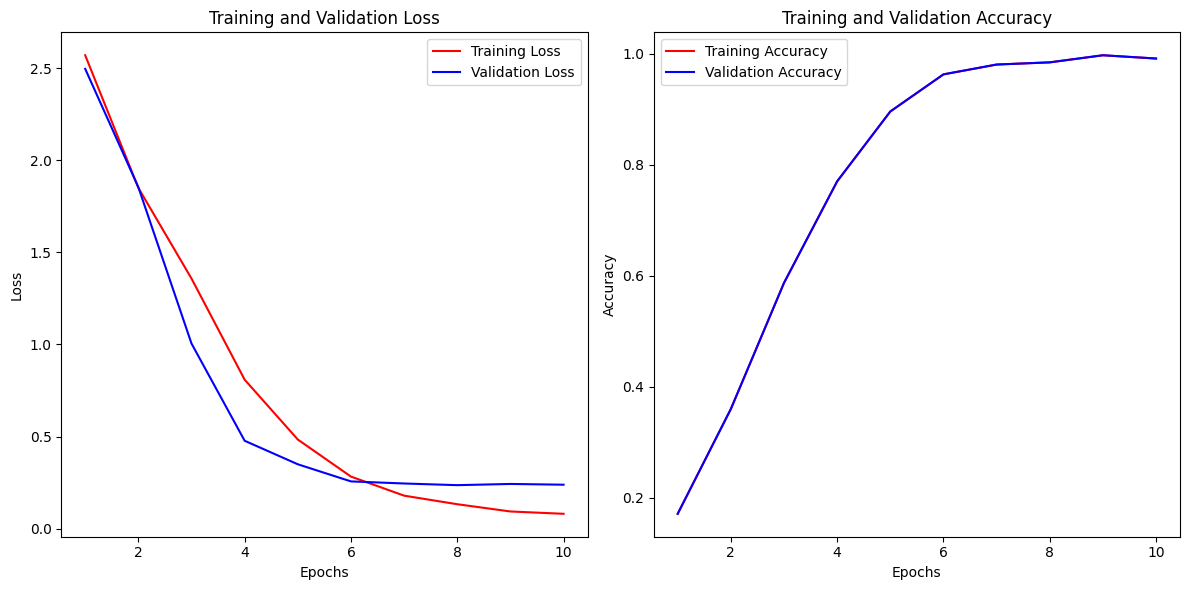

In [ ]:
# plot learning curve

epochs= range(1,11)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'r-', label="Training Loss")
plt.plot(epochs, val_loss, 'b-', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracy, 'r-', label="Training Accuracy")
plt.plot(epochs, val_accuracy, 'b-', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# start prediction timer
start_train_time = time.time()

#predictions
preds = model.predict(x_val)

4/4 [==============================] - 0s 70ms/step


In [ ]:
CLASSES = np.array(class_names)

In [ ]:
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_val, axis=-1)]

# Ender prediction timer
end_train_time = time.time()
train_time = end_train_time - start_train_time

In [ ]:
# After evaluating the model and generating predictions

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming preds_single and actual_single are defined as per your script
accuracy = accuracy_score(actual_single, preds_single)
precision = precision_score(actual_single, preds_single, average='weighted')
recall = recall_score(actual_single, preds_single, average='weighted')
f1 = f1_score(actual_single, preds_single, average='weighted')

# Save the metrics to a file
with open("metrics.txt", "w") as file:
    file.write(f"{accuracy}\n")
    file.write(f"{precision}\n")
    file.write(f"{recall}\n")
    file.write(f"{f1}\n")

# Optionally, print the metrics for quick reference
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9464285714285714
Precision: 0.9540480665950591
Recall: 0.9464285714285714
F1 Score: 0.9474161619065155


In [ ]:
import subprocess
import os
import csv
from datetime import datetime
import time
import getpass

# Run the training and evaluation script and capture output

#subprocess.run(["python3", "test_code_chai.py"])

#train_time = end_train_time - start_train_time

# For simplicity, we assume it's a constant small value here
pred_one_time = 0.01

# Load metrics generated by train_eval.py
with open("metrics.txt", "r") as file:
    lines = file.readlines()
    accuracy = float(lines[0].strip())
    precision = float(lines[1].strip())
    recall = float(lines[2].strip())
    f1 = float(lines[3].strip())

# Log results to CSV
csv_file = "results.csv"
fieldnames = ["name", "model", "train_time", "test_time", "pred_one_time", "accuracy", "precision", "recall", "f1"]

name = getpass.getuser()  # Get the username of the person running the script
model = "Original-CNN-Kaggle"  # Assuming CNN is the model used; modify if needed
#details = "whatever you want"
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()

with open(csv_file, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writerow({
        "name": name,
        "model": model,
        "train_time": train_time,
        "test_time": test_time,
        "pred_one_time": pred_one_time,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })
#"test_time": test_time,

In [ ]:
import pandas as pd
df = pd.read_csv(csv_file)
print(df)

        name                model  train_time  pred_one_time  accuracy  \
0  hrcprasad  Original-CNN-Kaggle   135.46026           0.01  0.946429   

   precision    recall        f1  
0   0.954048  0.946429  0.947416  
